In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

MIN_LENGTH = 100_000

# Load embeddings (col 0 = length, cols 1-384 = embeddings)
data = np.load('Runs/embeddings_SFE_SE_1.npy')
all_lengths = data[:, 0]
long_mask = all_lengths >= MIN_LENGTH
print(f'Total sequences: {len(all_lengths):,}')
print(f'Sequences >= {MIN_LENGTH:,} bp: {long_mask.sum():,} ({100 * long_mask.mean():.1f}%)')

lengths = all_lengths[long_mask]
embeddings = data[long_mask, 1:]
del data, all_lengths
print(f'Loaded {embeddings.shape[0]:,} embeddings with {embeddings.shape[1]} dimensions')
print(f'Length range: {lengths.min():.0f} - {lengths.max():.0f}')

# Pre-compute L2-normalized embeddings for cosine distance via dot product
norms = np.linalg.norm(embeddings, axis = 1, keepdims = True)
embeddings_normed = embeddings / norms
del norms

# Load embedding IDs (filter to same mask)
all_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
embedding_ids = all_ids[long_mask]
del all_ids
print(f'Loaded {embedding_ids.shape[0]:,} embedding IDs')

# Load k-mer frequencies (col 0 = length, cols 1-2772 = k-mers)
kmers = np.load('Runs/kmers_SFE_SE_1.npy')[long_mask]
print(f'Loaded k-mer data: {kmers.shape}')

del long_mask

# Extract k-mer frequencies by size (new format without 7-mers)
six_mers = kmers[:, 1:2081]        # 2080 features
five_mers = kmers[:, 2081:2593]    # 512 features
four_mers = kmers[:, 2593:2729]    # 136 features
three_mers = kmers[:, 2729:2761]   # 32 features
two_mers = kmers[:, 2761:2771]     # 10 features
one_mers = kmers[:, 2771:2773]     # 2 features

print(f'6-mers: {six_mers.shape[1]} features')
print(f'5-mers: {five_mers.shape[1]} features')
print(f'4-mers: {four_mers.shape[1]} features')
print(f'3-mers: {three_mers.shape[1]} features')
print(f'2-mers: {two_mers.shape[1]} features')
print(f'1-mers: {one_mers.shape[1]} features')

Total sequences: 6,693,829
Sequences >= 100,000 bp: 154,040 (2.3%)
Loaded 154,040 embeddings with 384 dimensions
Length range: 100000 - 10208085
Loaded 154,040 embedding IDs
Loaded k-mer data: (154040, 2773)
6-mers: 2080 features
5-mers: 512 features
4-mers: 136 features
3-mers: 32 features
2-mers: 10 features
1-mers: 2 features



Number of pairwise distances: 49,995,000
Distance range: 0.05 - 42.22
Mean: 11.75, Std: 2.01


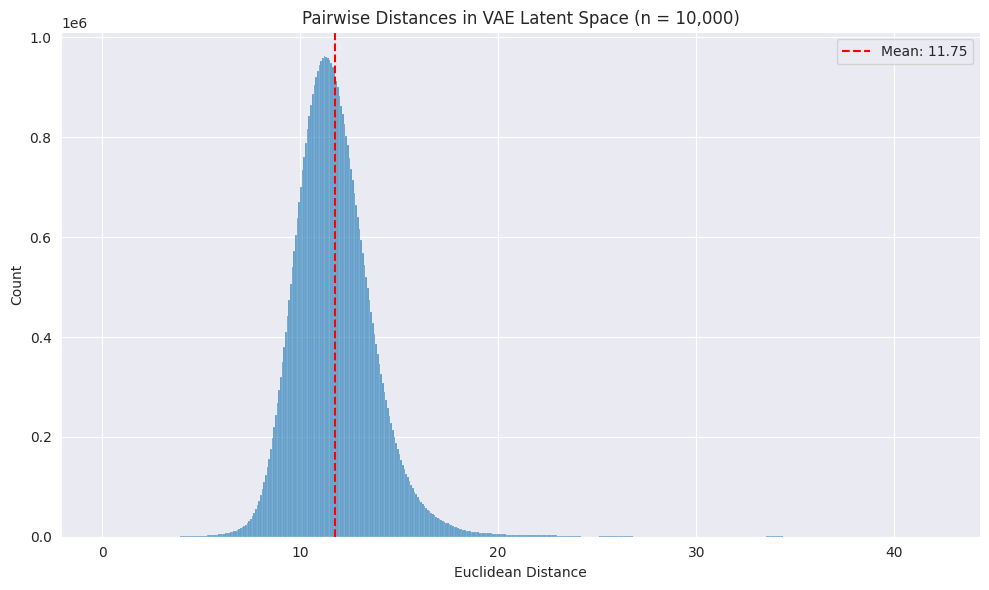

In [2]:
# Randomly sample 10,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 10_000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances (float32 via squared-distance decomposition)
sq_norms = np.einsum('ij,ij->i', sample, sample)
sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample @ sample.T)
np.maximum(sq_dists, 0, out = sq_dists)  # Clamp numerical noise
np.fill_diagonal(sq_dists, 0)
# Extract upper triangle (same as pdist output)
distances = np.sqrt(sq_dists[np.triu_indices(len(sample), k = 1)])

print(f'\nNumber of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sq_norms, sq_dists

Number of pairwise distances: 49,995,000
Distance range: 0.0000 - 1.4338
Mean: 0.9910, Std: 0.0961


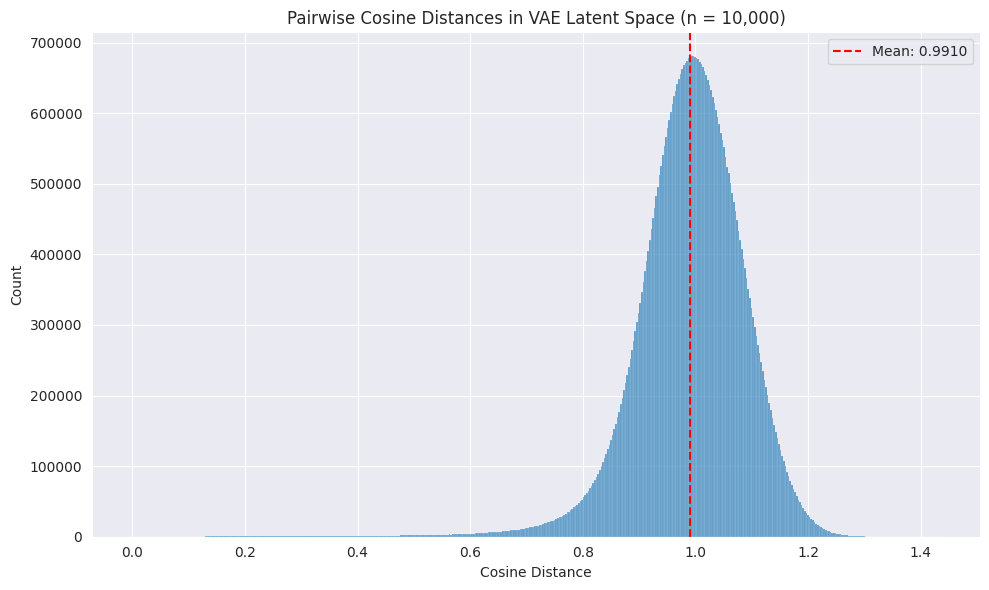

In [3]:
# Calculate pairwise cosine distances (using same sample, float32 via dot product)
sample_norms = np.linalg.norm(sample, axis = 1, keepdims = True)
sample_normed = sample / sample_norms
cos_sims = sample_normed @ sample_normed.T
np.clip(cos_sims, -1, 1, out = cos_sims)
cos_dists = 1 - cos_sims
cosine_distances = cos_dists[np.triu_indices(len(sample), k = 1)]

print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(cosine_distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sample_normed, cos_sims, cos_dists

Total 6-mer frequency values: 320,403,200
Range: 0.000000 - 0.234482
Mean: 0.000481, Std: 0.000464


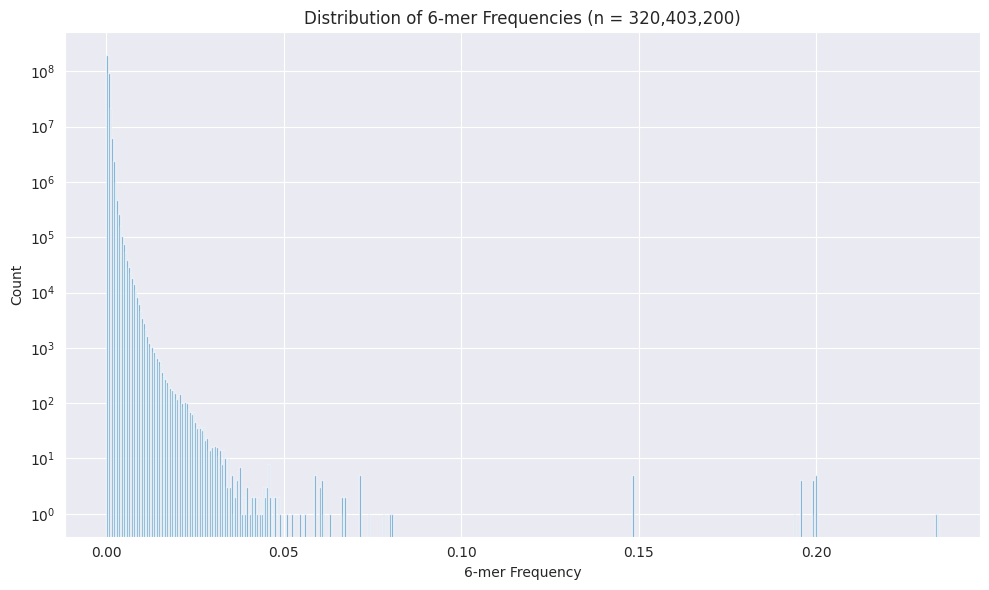

In [4]:
# Analyze 6-mer frequency distribution (using six_mers view, no flatten)
print(f'Total 6-mer frequency values: {six_mers.size:,}')
print(f'Range: {six_mers.min():.6f} - {six_mers.max():.6f}')
print(f'Mean: {six_mers.mean():.6f}, Std: {six_mers.std():.6f}')

# Compute histogram in chunks to avoid 56 GB flatten
bins = np.linspace(six_mers.min(), six_mers.max(), 501)
counts = np.zeros(len(bins) - 1, dtype = np.int64)
chunk_size = 100_000
for start in range(0, len(six_mers), chunk_size):
    chunk = six_mers[start:start + chunk_size].ravel()
    c, _ = np.histogram(chunk, bins = bins)
    counts += c

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
bin_widths = np.diff(bins)
ax.bar(bins[:-1], counts, width = bin_widths, alpha = 0.7, align = 'edge')
ax.set_yscale('log')
ax.set_xlabel('6-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 6-mer Frequencies (n = {six_mers.size:,})')
plt.tight_layout()
plt.show()

In [ ]:
## Analyze 6-mer frequency distribution
## How many 6-mers occur less than 1% of the time
#threshold = 0.01
#rare_counts = np.sum(six_mers < threshold, axis = 1)
#
#print(f'6-mer rarity analysis (threshold: {threshold * 100:.0f}%)')
#print(f'Total 6-mers per sequence: {six_mers.shape[1]}')
#print(f'Rare 6-mers per sequence (< {threshold * 100:.0f}%):')
#print(f'  Mean: {rare_counts.mean():.1f}')
#print(f'  Min: {rare_counts.min()}')
#print(f'  Max: {rare_counts.max()}')
#print(f'  Median: {np.median(rare_counts):.0f}')
#
## Plot histogram
#fig, ax = plt.subplots(figsize = (10, 6))
#sns.histplot(rare_counts, bins = 100, alpha = 0.7, ax = ax)
#ax.axvline(rare_counts.mean(), color = 'red', linestyle = '--', label = f'Mean: {rare_counts.mean():.1f}')
#ax.set_xlabel(f'Number of 6-mers with frequency < {threshold * 100:.0f}%')
#ax.set_ylabel('Count (sequences)')
#ax.set_title(f'Distribution of Rare 6-mer Counts (n = {len(rare_counts):,})')
#ax.legend()
#plt.tight_layout()
#plt.show()

Sampled 100,000 sequences
Sequences with at least one neighbor within 5.0 Euclidean distance: 77,901 (77.90%)
Minimum distance found: 0.0396
Mean nearest neighbor distance: 3.8265


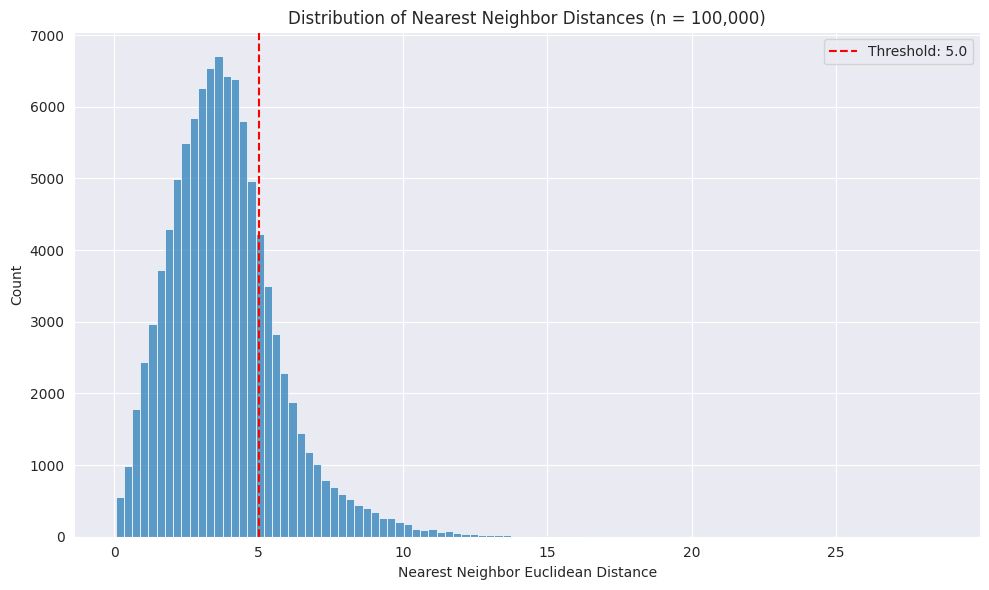

In [5]:
# Sample 100,000 sequences and check for close neighbors (float32 Euclidean)
sample_size = 100_000
neighbor_threshold = 5.0

rng_sample = np.random.default_rng(123)
sample_idx = rng_sample.choice(len(embeddings), size = sample_size, replace = False)
sample_embeddings = embeddings[sample_idx]

# Pre-compute squared norms for ||a-b||² = ||a||² + ||b||² - 2·a·b
sq_norms = np.einsum('ij,ij->i', sample_embeddings, sample_embeddings)

# Compute nearest-neighbor distances in chunks (~2 GB per chunk in float32)
min_distances = np.full(sample_size, np.inf, dtype = np.float32)
chunk_size = 5_000
for start in range(0, sample_size, chunk_size):
    end = min(start + chunk_size, sample_size)
    # Squared Euclidean distances
    sq_dists = sq_norms[start:end, None] + sq_norms[None, :] - 2 * (sample_embeddings[start:end] @ sample_embeddings.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    min_distances[start:end] = np.sqrt(sq_dists.min(axis = 1))
    del sq_dists

has_close_neighbor = min_distances < neighbor_threshold

print(f'Sampled {sample_size:,} sequences')
print(f'Sequences with at least one neighbor within {neighbor_threshold} Euclidean distance: {has_close_neighbor.sum():,} ({100 * has_close_neighbor.mean():.2f}%)')
print(f'Minimum distance found: {min_distances.min():.4f}')
print(f'Mean nearest neighbor distance: {min_distances.mean():.4f}')

# Plot histogram of minimum distances
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(min_distances, bins = 100, alpha = 0.7, ax = ax)
ax.axvline(neighbor_threshold, color = 'red', linestyle = '--', label = f'Threshold: {neighbor_threshold}')
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Nearest Neighbor Distances (n = {sample_size:,})')
ax.legend()
plt.tight_layout()
plt.show()

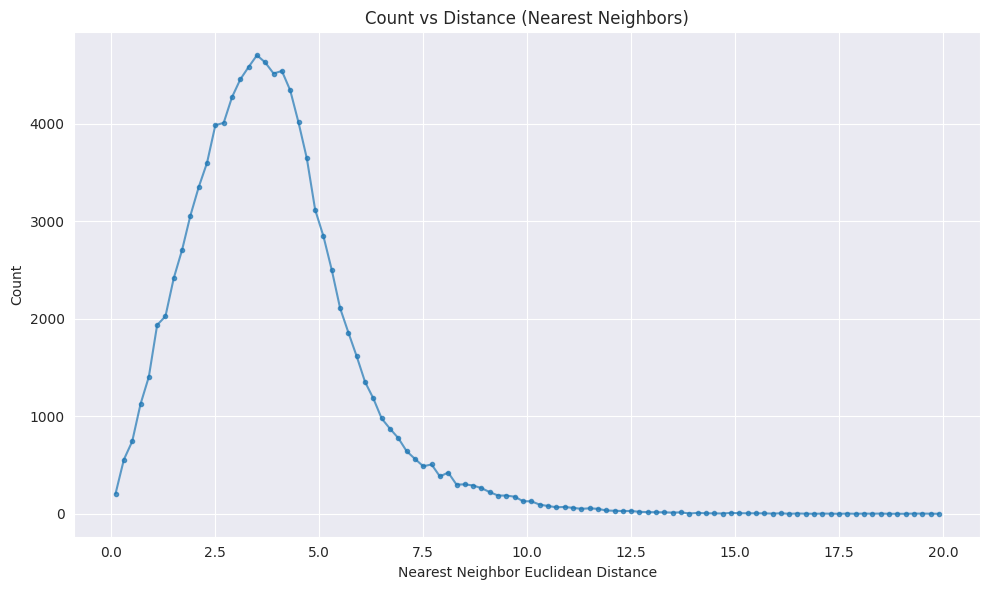

Linear fit: count = -185.2 * distance + 2852.4
R² = 0.5095


In [6]:
# Plot count vs distance (binned)
max_dist = 20.0
bins = np.linspace(0, max_dist, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2
counts, _ = np.histogram(min_distances[min_distances < max_dist], bins = bins)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(bin_centers, counts, 'o-', markersize = 3, alpha = 0.7)
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Count vs Distance (Nearest Neighbors)')
plt.tight_layout()
plt.show()

# Fit a linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, counts)
print(f'Linear fit: count = {slope:.1f} * distance + {intercept:.1f}')
print(f'R² = {r_value**2:.4f}')

TWO-NN intrinsic dimensionality estimate: d̂ = 3.74
Valid μ values: 100,000 / 100,000
μ range: 1.000001 - 151.579564, mean: 1.312946


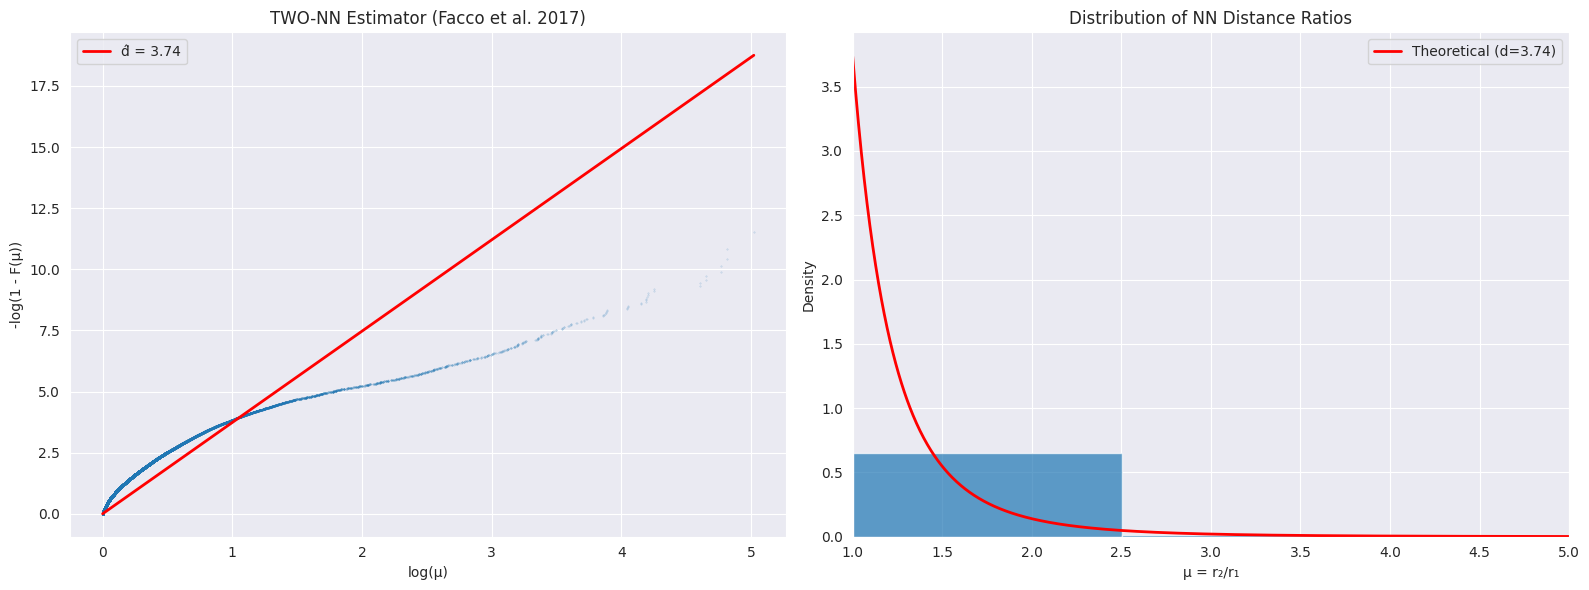

In [7]:
# TWO-NN intrinsic dimensionality estimator (Facco et al. 2017)
# Uses sample_embeddings from cell 8

# Cast to float64 for distance precision (100K × 384 = ~300 MB)
sample_f64 = sample_embeddings.astype(np.float64)
sq_norms_f64 = np.einsum('ij,ij->i', sample_f64, sample_f64)

# Find two nearest neighbors per point in chunks (~4 GB per chunk in float64)
n_sample = len(sample_f64)
nn1 = np.full(n_sample, np.inf)
nn2 = np.full(n_sample, np.inf)
chunk_size = 5_000
for start in range(0, n_sample, chunk_size):
    end = min(start + chunk_size, n_sample)
    sq_dists = sq_norms_f64[start:end, None] + sq_norms_f64[None, :] - 2 * (sample_f64[start:end] @ sample_f64.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    # Two smallest squared distances per row
    top2_sq = np.partition(sq_dists, 1, axis = 1)[:, :2]
    top2_sq.sort(axis = 1)
    nn1[start:end] = np.sqrt(top2_sq[:, 0])
    nn2[start:end] = np.sqrt(top2_sq[:, 1])
    del sq_dists, top2_sq

del sample_f64, sq_norms_f64

# Compute μ = r₂/r₁
mu = nn2 / nn1
valid = np.isfinite(mu) & (mu > 1)
mu = np.sort(mu[valid])

# Empirical CDF
n = len(mu)
F_emp = np.arange(1, n + 1) / n

# Fit: from F(μ) = 1 - μ^(-d), we get -log(1 - F) = d * log(μ)
# Slope through origin = d̂
x = np.log(mu[:-1])  # exclude last point where F_emp = 1
y = -np.log(1 - F_emp[:-1])
d_hat = np.sum(x * y) / np.sum(x * x)

print(f'TWO-NN intrinsic dimensionality estimate: d̂ = {d_hat:.2f}')
print(f'Valid μ values: {n:,} / {n_sample:,}')
print(f'μ range: {mu.min():.6f} - {mu.max():.6f}, mean: {mu.mean():.6f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Left: log(μ) vs -log(1-F) with fitted line
axes[0].scatter(x, y, s = 0.1, alpha = 0.3)
x_fit = np.linspace(0, x.max(), 100)
axes[0].plot(x_fit, d_hat * x_fit, 'r-', linewidth = 2, label = f'd̂ = {d_hat:.2f}')
axes[0].set_xlabel('log(μ)')
axes[0].set_ylabel('-log(1 - F(μ))')
axes[0].set_title('TWO-NN Estimator (Facco et al. 2017)')
axes[0].legend()

# Right: histogram of μ with theoretical PDF f(μ) = d * μ^(-(d+1))
axes[1].hist(mu, bins = 100, alpha = 0.7, density = True)
mu_theory = np.linspace(1, min(5, mu.max()), 1000)
pdf_theory = d_hat * mu_theory ** (-(d_hat + 1))
axes[1].plot(mu_theory, pdf_theory, 'r-', linewidth = 2, label = f'Theoretical (d={d_hat:.2f})')
axes[1].set_xlabel('μ = r₂/r₁')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of NN Distance Ratios')
axes[1].legend()
axes[1].set_xlim(1, min(5, mu.max()))

plt.tight_layout()
plt.show()

In [8]:
# t-SNE visualization using openTSNE (full dataset)
from openTSNE import TSNE

# Use all embeddings
tsne_sample_size = len(embeddings)
tsne_idx = np.arange(tsne_sample_size)
tsne_embeddings = embeddings
tsne_ids = embedding_ids
tsne_lengths = lengths

print(f'Using all {tsne_sample_size:,} embeddings for t-SNE')
print(f'Running t-SNE (this may take a while)...')

# Run t-SNE with Euclidean metric (better for this VAE than cosine)
tsne = TSNE(
    n_components = 2,
    perplexity = 30,
    metric = 'euclidean',
    n_jobs = -1,  # Use all cores
    random_state = 42,
    verbose = True
)
tsne_result = tsne.fit(tsne_embeddings)

print(f't-SNE complete. Result shape: {tsne_result.shape}')

Using all 154,040 embeddings for t-SNE
Running t-SNE (this may take a while)...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 12.28 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.44 seconds
===> Running optimization with exaggeration=12.00, lr=12836.67 for 250 iterations...
Iteration   50, KL divergence 6.0464, 50 iterations in 2.1374 sec
Iteration  100, KL divergence 5.4100, 50 iterations in 2.1275 sec
Iteration  150, KL divergence 5.0745, 50 iterations in 2.1396 sec
Iteration  200, KL divergence 4.8609, 50 iterations in 2.1423 sec
Iteration  250, KL divergence 4.7093, 50 iterations in 2.1070 

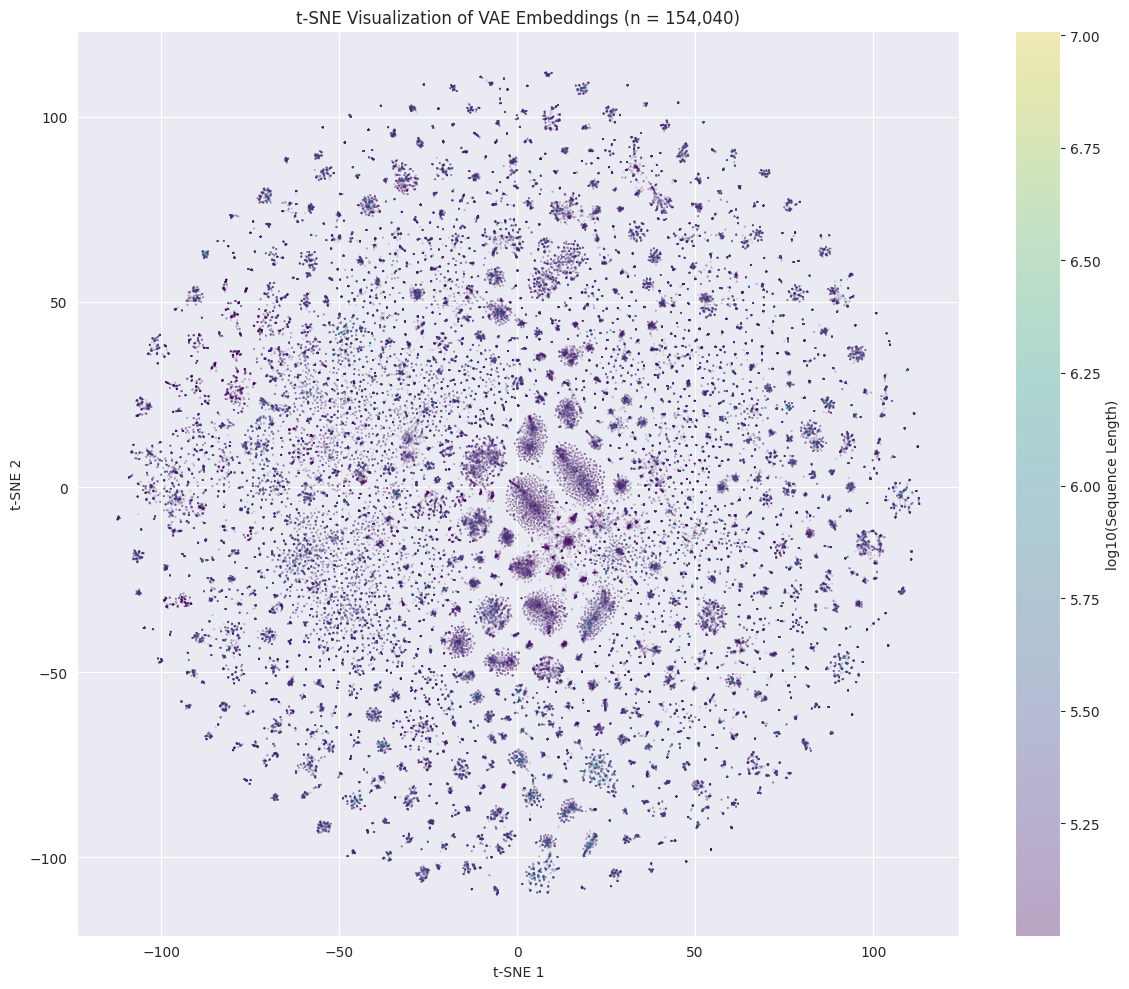

In [9]:
# Plot t-SNE result
fig, ax = plt.subplots(figsize = (12, 10))

# Use scatter with small alpha for 1M points
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = np.log10(tsne_lengths),  # Color by log sequence length
    cmap = 'viridis',
    s = 0.1,
    alpha = 0.3
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('log10(Sequence Length)')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Visualization of VAE Embeddings (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

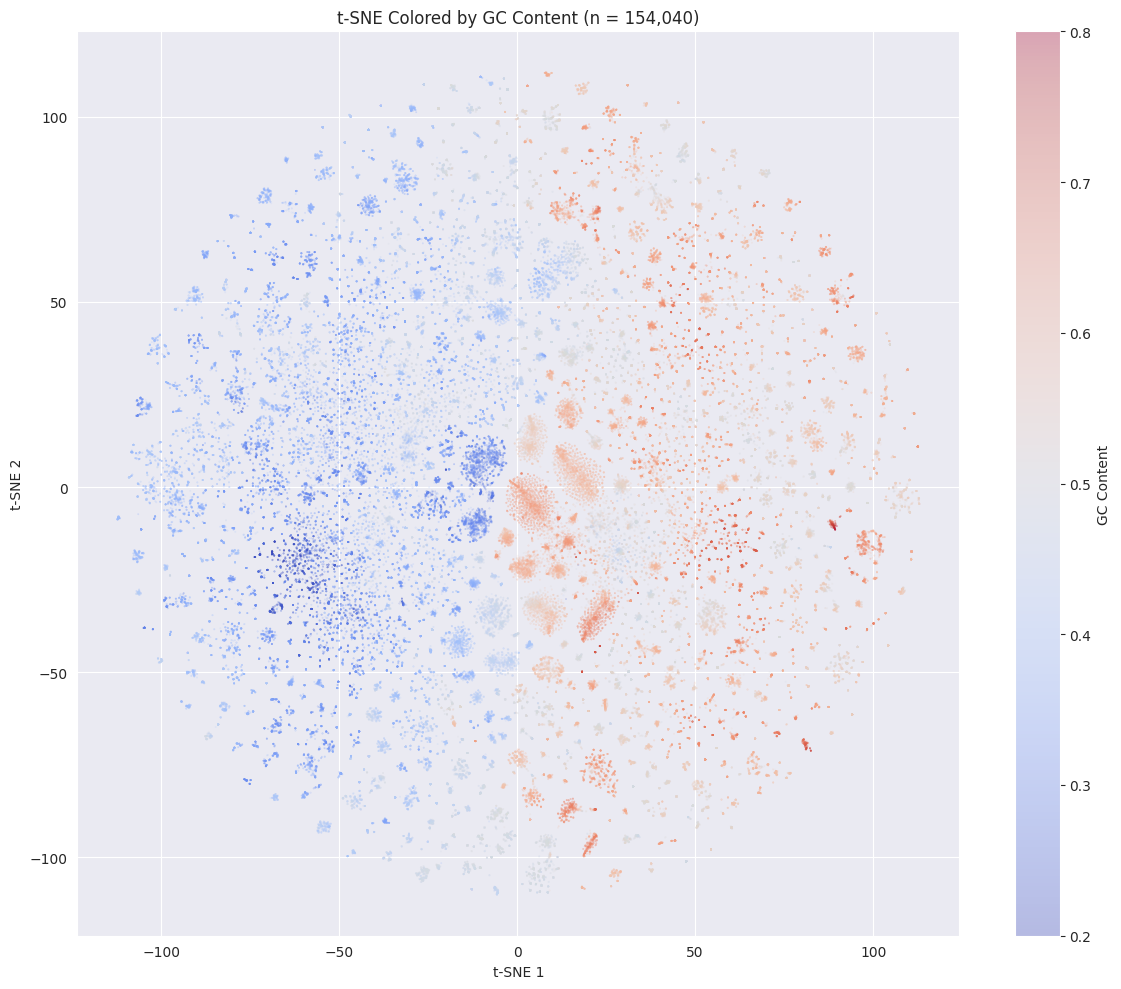

GC content range: 0.141 - 0.829
GC content mean: 0.477


In [10]:
# Plot t-SNE colored by GC content (last column of kmers)
gc_content = kmers[tsne_idx, -1]

fig, ax = plt.subplots(figsize = (12, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = gc_content,
    cmap = 'coolwarm',
    s = 0.1,
    alpha = 0.3,
    vmin = 0.2,
    vmax = 0.8
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('GC Content')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Colored by GC Content (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

print(f'GC content range: {gc_content.min():.3f} - {gc_content.max():.3f}')
print(f'GC content mean: {gc_content.mean():.3f}')

SFE sequences: 81,295 (52.8%)
SE sequences: 72,745 (47.2%)


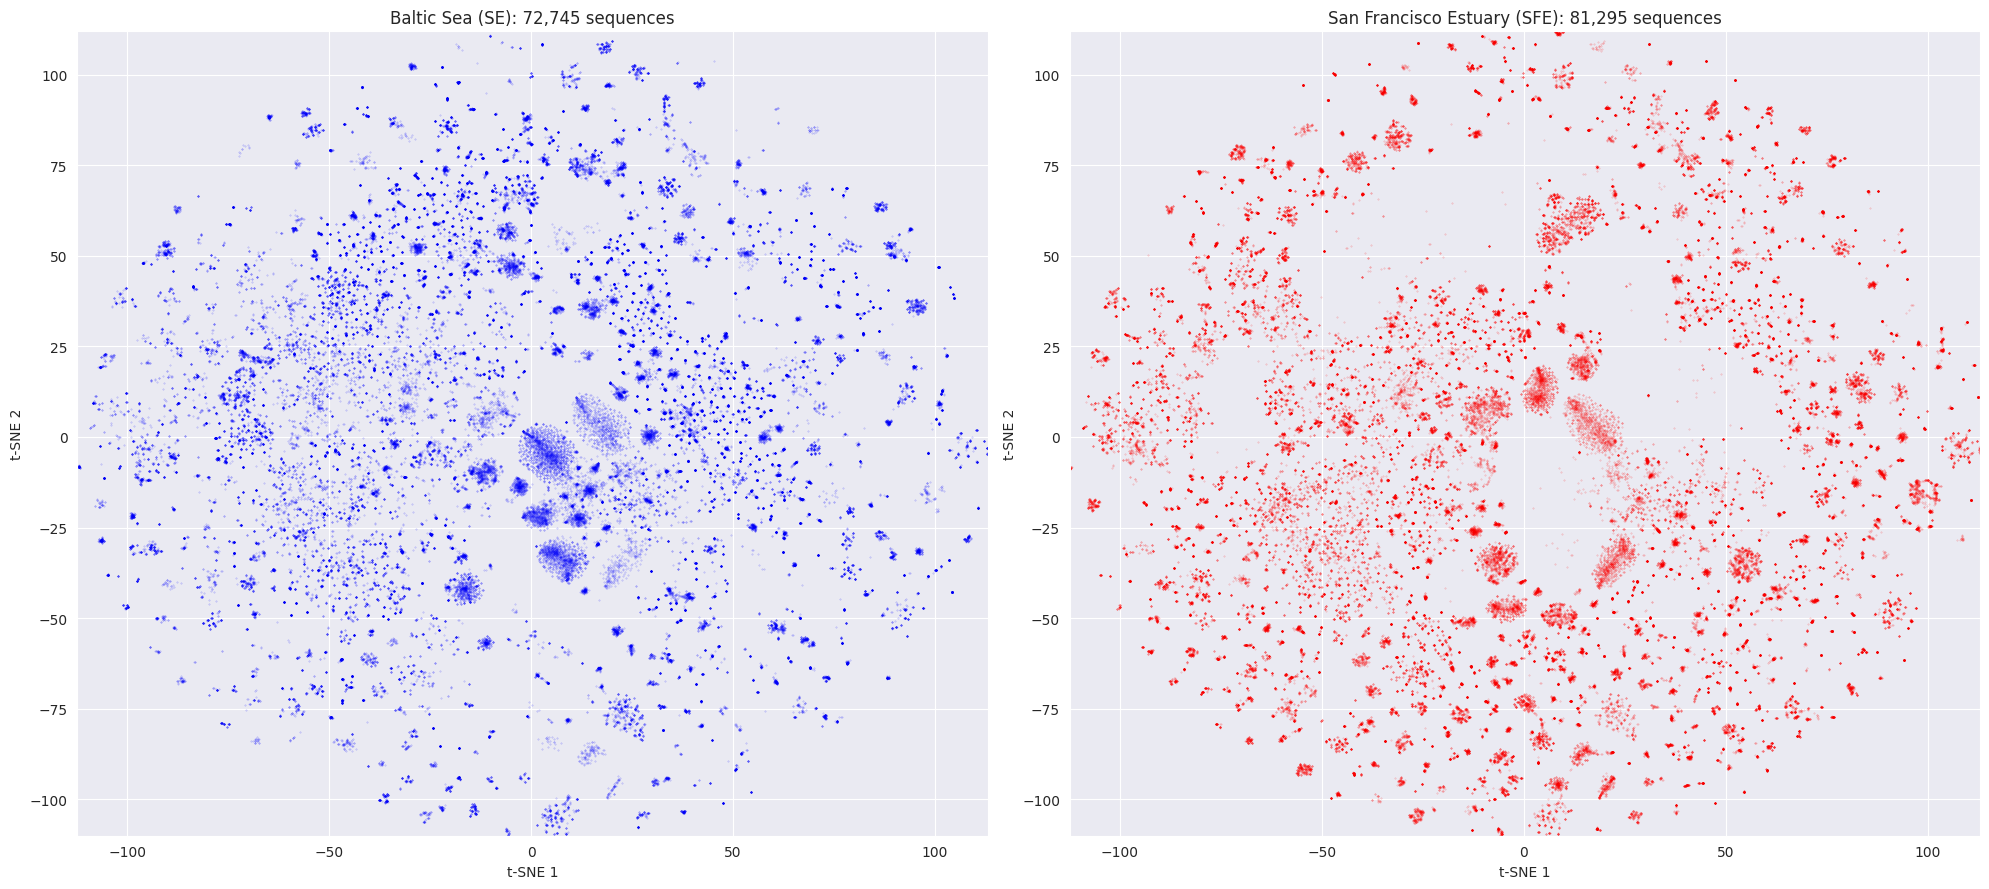

In [11]:
# Plot t-SNE colored by ID prefix (SFE vs SE) - side by side
is_sfe = np.array([id.startswith('SFE') for id in tsne_ids])
is_se = np.array([id.startswith('SE') for id in tsne_ids])

print(f'SFE sequences: {is_sfe.sum():,} ({100 * is_sfe.mean():.1f}%)')
print(f'SE sequences: {is_se.sum():,} ({100 * is_se.mean():.1f}%)')

fig, axes = plt.subplots(1, 2, figsize = (20, 9))

# Left: SE only (Baltic)
axes[0].scatter(
    tsne_result[is_se, 0],
    tsne_result[is_se, 1],
    c = 'blue',
    s = 0.1,
    alpha = 0.3
)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'Baltic Sea (SE): {is_se.sum():,} sequences')

# Right: SFE only (San Francisco Estuary)
axes[1].scatter(
    tsne_result[is_sfe, 0],
    tsne_result[is_sfe, 1],
    c = 'red',
    s = 0.1,
    alpha = 0.3
)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'San Francisco Estuary (SFE): {is_sfe.sum():,} sequences')

# Match axis limits so they're comparable
xlim = (tsne_result[:, 0].min(), tsne_result[:, 0].max())
ylim = (tsne_result[:, 1].min(), tsne_result[:, 1].max())
for ax in axes:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.tight_layout()
plt.show()

Running HDBSCAN on 154,040 points...


/home/torben/Embedding/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/torben/Embedding/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found: 462
Noise points: 33,681 (21.9%)


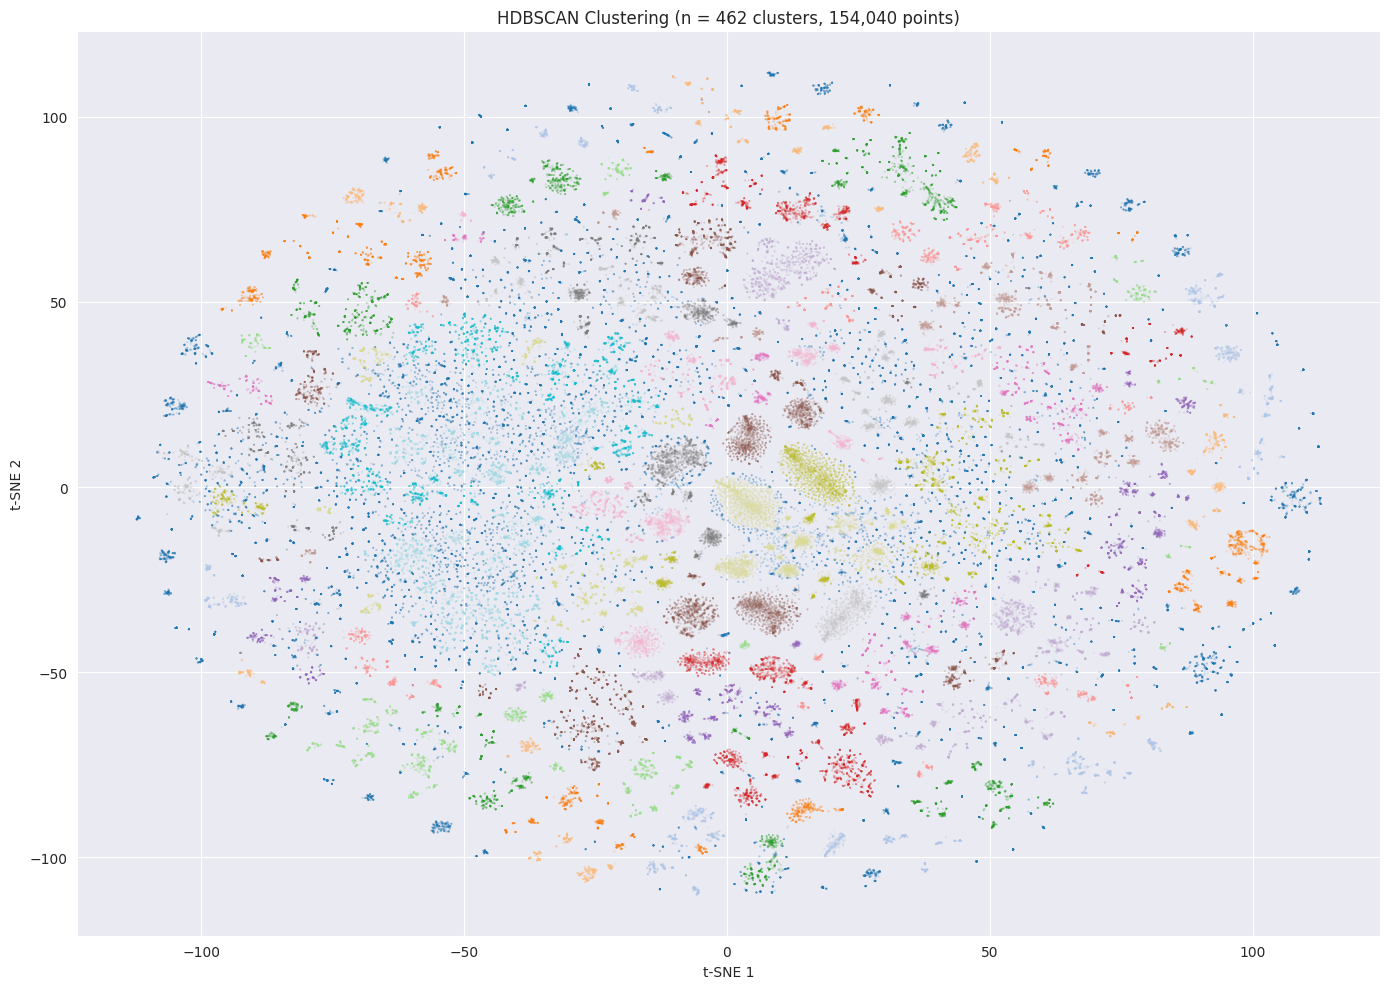

In [12]:
# HDBSCAN clustering on full t-SNE coordinates
from hdbscan import HDBSCAN

print(f'Running HDBSCAN on {len(tsne_result):,} points...')
clusterer = HDBSCAN(min_cluster_size = 100, min_samples = 50)
labels = clusterer.fit_predict(tsne_result)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print(f'Clusters found: {n_clusters}')
print(f'Noise points: {n_noise:,} ({100 * n_noise / len(labels):.1f}%)')

# Plot with cluster colors
fig, ax = plt.subplots(figsize = (14, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = labels,
    cmap = 'tab20',
    s = 0.1,
    alpha = 0.3
)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'HDBSCAN Clustering (n = {n_clusters} clusters, {len(tsne_result):,} points)')
plt.tight_layout()
plt.show()

In [13]:
# List clusters and save to files
unique_labels = sorted(set(labels) - {-1})  # Exclude noise

# Save cluster sizes to clusters.tsv
with open('clusters.tsv', 'w') as f:
    f.write('cluster\tsize\n')
    for label in unique_labels:
        size = (labels == label).sum()
        f.write(f'{label}\t{size}\n')
    f.write(f'noise\t{(labels == -1).sum()}\n')

print(f'Saved cluster sizes to clusters.tsv')

# Save cluster memberships to cluster_members.tsv
with open('cluster_members.tsv', 'w') as f:
    f.write('cluster\tsequence_ids\n')
    for label in unique_labels:
        mask = labels == label
        ids = embedding_ids[mask]
        f.write(f'{label}\t{",".join(ids)}\n')

print(f'Saved cluster memberships to cluster_members.tsv')

Saved cluster sizes to clusters.tsv
Saved cluster memberships to cluster_members.tsv


In [14]:
# Phase 1: Distance landscape from kNN graph
# Parse nn1, nn2, and nn50 distances from neighbors TSV

tsv_path = 'Runs/neighbors_SFE_SE_100.tsv'
n_sequences = len(embeddings)

nn1_dists = np.empty(n_sequences, dtype = np.float32)
nn2_dists = np.empty(n_sequences, dtype = np.float32)
nn50_dists = np.empty(n_sequences, dtype = np.float32)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        nn1_dists[i] = float(fields[1].split('(')[1].rstrip(')'))
        nn2_dists[i] = float(fields[2].split('(')[1].rstrip(')'))
        nn50_dists[i] = float(fields[-1].split('(')[1].rstrip(')'))
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,} lines...')

print(f'\nParsed all {n_sequences:,} lines')
print(f'nn1  range: {nn1_dists.min():.4f} - {nn1_dists.max():.4f}, mean: {nn1_dists.mean():.4f}, median: {np.median(nn1_dists):.4f}')
print(f'nn2  range: {nn2_dists.min():.4f} - {nn2_dists.max():.4f}, mean: {nn2_dists.mean():.4f}, median: {np.median(nn2_dists):.4f}')
print(f'nn50 range: {nn50_dists.min():.4f} - {nn50_dists.max():.4f}, mean: {nn50_dists.mean():.4f}, median: {np.median(nn50_dists):.4f}')

# Percentiles
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f'nn1 P{p:2d}: {np.percentile(nn1_dists, p):.4f}    nn50 P{p:2d}: {np.percentile(nn50_dists, p):.4f}')


Parsed all 154,040 lines
nn1  range: 0.0111 - 32.3450, mean: 3.6857, median: 3.4220
nn2  range: 0.0413 - 32.4534, mean: 4.1948, median: 3.9512
nn50 range: 1.6626 - 32.7258, mean: 6.5221, median: 6.0932
nn1 P 1: 0.4116    nn50 P 1: 3.1635
nn1 P 5: 0.9914    nn50 P 5: 3.8554
nn1 P10: 1.4133    nn50 P10: 4.2719
nn1 P25: 2.2880    nn50 P25: 4.9945
nn1 P50: 3.4220    nn50 P50: 6.0932
nn1 P75: 4.6488    nn50 P75: 7.6823
nn1 P90: 6.0945    nn50 P90: 9.3297
nn1 P95: 7.4461    nn50 P95: 10.4541
nn1 P99: 10.5808    nn50 P99: 13.0289


Parsed all 154,040 sequences, 50 neighbors each


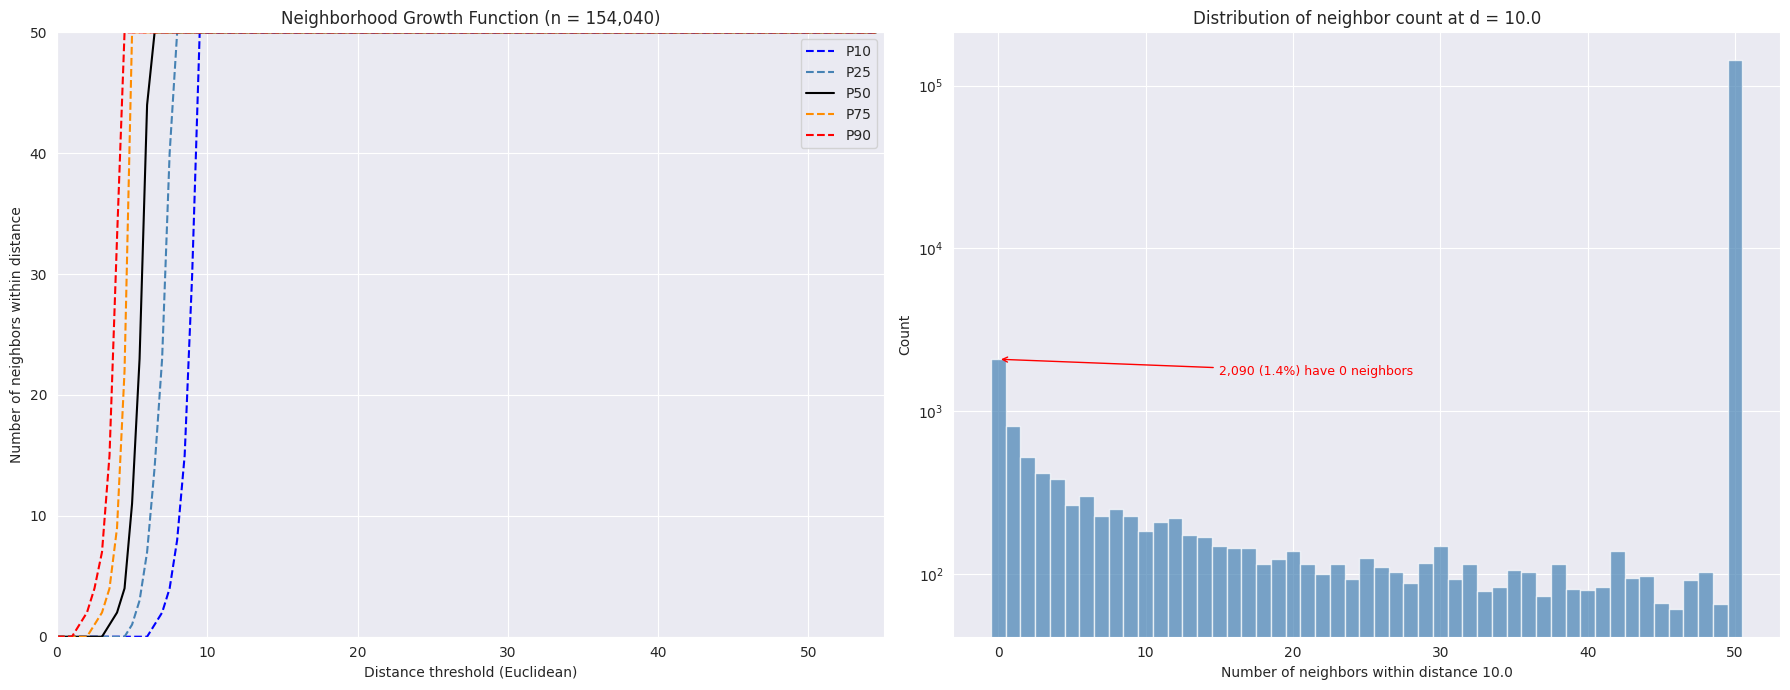


Neighbors within distance d (percentiles across 154,040 sequences):
     d    P10    P25    P50    P75    P90    Mean
     2      0      0      0      0      2     0.6
     5      0      1     11     50     50    20.2
     8      8     50     50     50     50    42.5
    10     50     50     50     50     50    47.6
    12     50     50     50     50     50    49.3
    15     50     50     50     50     50    49.8
    20     50     50     50     50     50    50.0
    25     50     50     50     50     50    50.0
    30     50     50     50     50     50    50.0


In [15]:
# Neighborhood growth: how many neighbors within distance d?
# Parse all 50 neighbor distances for ALL sequences

tsv_path = 'Runs/neighbors_SFE_SE_100.tsv'
n_sequences = len(embeddings)

# Distance thresholds to evaluate
d_thresholds = np.arange(0, 55, 0.5)
n_thresholds = len(d_thresholds)

# For each sequence, count neighbors within each distance threshold
counts = np.zeros((n_sequences, n_thresholds), dtype = np.int16)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        dists = np.empty(len(fields) - 1, dtype = np.float32)
        for j, field in enumerate(fields[1:]):
            paren = field.rfind('(')
            dists[j] = float(field[paren + 1:-1])
        # Vectorized: count neighbors within each threshold
        counts[i] = np.searchsorted(dists, d_thresholds, side = 'right')
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,}...')

print(f'Parsed all {n_sequences:,} sequences, {len(dists)} neighbors each')

# Plot percentile curves
fig, axes = plt.subplots(1, 2, figsize = (18, 7))

# Left: percentile curves of N(d)
for p, color, ls in [(10, 'blue', '--'), (25, 'steelblue', '--'),
                      (50, 'black', '-'), (75, 'darkorange', '--'),
                      (90, 'red', '--')]:
    pct = np.percentile(counts, p, axis = 0)
    axes[0].plot(d_thresholds, pct, color = color, linestyle = ls, linewidth = 1.5,
                 label = f'P{p}')
axes[0].set_xlabel('Distance threshold (Euclidean)')
axes[0].set_ylabel('Number of neighbors within distance')
axes[0].set_title(f'Neighborhood Growth Function (n = {n_sequences:,})')
axes[0].legend()
axes[0].set_xlim(0, 55)
axes[0].set_ylim(0, 50)

# Right: histogram of neighbors within distance 10
d_cutoff = 10.0
d_idx = np.argmin(np.abs(d_thresholds - d_cutoff))
n_within = counts[:, d_idx]
axes[1].hist(n_within, bins = np.arange(-0.5, 51.5, 1), alpha = 0.7, color = 'steelblue')
axes[1].set_yscale('log')
axes[1].set_xlabel(f'Number of neighbors within distance {d_cutoff}')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distribution of neighbor count at d = {d_cutoff}')
# Annotate
n_zero = (n_within == 0).sum()
axes[1].annotate(f'{n_zero:,} ({100 * n_zero / n_sequences:.1f}%) have 0 neighbors',
                 xy = (0, n_zero), fontsize = 9, color = 'red',
                 xytext = (15, n_zero * 0.8), arrowprops = dict(arrowstyle = '->', color = 'red'))

plt.tight_layout()
plt.show()

# Print stats at key thresholds
print(f'\nNeighbors within distance d (percentiles across {n_sequences:,} sequences):')
print(f'{"d":>6s}  {"P10":>5s}  {"P25":>5s}  {"P50":>5s}  {"P75":>5s}  {"P90":>5s}  {"Mean":>6s}')
for d in [2, 5, 8, 10, 12, 15, 20, 25, 30]:
    d_idx = np.argmin(np.abs(d_thresholds - d))
    col = counts[:, d_idx]
    print(f'{d:6.0f}  {np.percentile(col, 10):5.0f}  {np.percentile(col, 25):5.0f}  '
          f'{np.percentile(col, 50):5.0f}  {np.percentile(col, 75):5.0f}  '
          f'{np.percentile(col, 90):5.0f}  {col.mean():6.1f}')

In [16]:
# Distance-threshold clustering: connect sequences within d < 5
# Edges weighted by 1/(distance + epsilon) so Leiden prefers cutting distant edges
import igraph as ig
import leidenalg

d_threshold = 5.0
epsilon = 0.1
tsv_path = 'Runs/neighbors_SFE_SE_100.tsv'
n_sequences = len(embeddings)

# Build ID -> index mapping
id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse neighbors TSV, collect edges with distance < threshold
print(f'Building edge list with d < {d_threshold}, weights = 1/(d + {epsilon})...')
edges = []
weights = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break  # distance-sorted
            j = id_to_idx[field[:paren]]
            edges.append((i, j))
            weights.append(1.0 / (dist + epsilon))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(edges):,} edges so far)')

print(f'\nTotal directed edges: {len(edges):,}')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = edges, directed = True)
g.es['weight'] = weights
del edges, weights

# When collapsing to undirected, combine weights by max (keep strongest connection)
g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

component_labels = np.array(partition.membership)
component_sizes = np.bincount(component_labels)
n_components = len(component_sizes)
n_singletons = (component_sizes == 1).sum()
nonsingleton_sizes = np.sort(component_sizes[component_sizes > 1])[::-1]
n_clustered = component_sizes[component_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on distance-threshold graph (d < {d_threshold}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building edge list with d < 5.0, weights = 1/(d + 0.1)...

Total directed edges: 3,106,097
Building igraph graph...
Graph: 154,040 vertices, 2,152,557 edges
Weight range: 0.1961 - 9.0009, mean: 0.2561
Running Leiden (resolution=1.0, weighted)...

Leiden on distance-threshold graph (d < 5.0, weighted)
Quality (modularity): 1094177.8333
Total communities: 35,851
Singletons: 29,738 (19.3%)
Non-singleton communities: 6,113
Clustered sequences: 124,302 (80.7%)
  Size range: 2 - 1,806
  Mean size: 20.3
  Median size: 3

Top 20 communities:
    1. 1,806 sequences
    2. 1,471 sequences
    3. 1,426 sequences
    4. 1,011 sequences
    5. 994 sequences
    6. 952 sequences
    7. 948 sequences
    8. 938 sequences
    9. 936 sequences
   10. 875 sequences
   11. 865 sequences
   12. 851 sequences
   13. 823 sequences
   14. 810 sequences
   15. 788 sequences
   16. 778 sequences
   17. 772 sequences
   18. 719 sequences
   19. 719 sequences
   20. 682 sequences


In [17]:
# Mutual kNN Leiden: keep only edges where both directions exist
# Edges weighted by 1/(distance + epsilon)
import igraph as ig
import leidenalg

d_threshold = 5.0
epsilon = 0.1
tsv_path = 'Runs/neighbors_SFE_SE_100.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge set with d < {d_threshold}...')
directed_edges = {}  # (i, j) -> distance

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges[(i, j)] = dist
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} directed edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Pass 2: keep only mutual edges (both directions exist)
print('Filtering to mutual edges...')
mutual_edges = []
mutual_weights = []

seen = set()
for (i, j), dist_ij in directed_edges.items():
    if i < j and (j, i) in directed_edges:
        # Use the smaller distance (closer direction) for weight
        dist = min(dist_ij, directed_edges[(j, i)])
        mutual_edges.append((i, j))
        mutual_weights.append(1.0 / (dist + epsilon))

del directed_edges

# Count connected vs isolated nodes
connected = set()
for i, j in mutual_edges:
    connected.add(i)
    connected.add(j)
n_connected = len(connected)
del connected

print(f'Mutual edges: {len(mutual_edges):,}')
print(f'Connected nodes: {n_connected:,} ({100 * n_connected / n_sequences:.1f}%)')
print(f'Isolated nodes: {n_sequences - n_connected:,} ({100 * (1 - n_connected / n_sequences):.1f}%)')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = mutual_edges, directed = False)
g.es['weight'] = mutual_weights
del mutual_edges, mutual_weights

w = np.array(g.es['weight'])
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, mutual kNN)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

mutual_labels = np.array(partition.membership)
mutual_sizes = np.bincount(mutual_labels)
n_components = len(mutual_sizes)
n_singletons = (mutual_sizes == 1).sum()
nonsingleton_sizes = np.sort(mutual_sizes[mutual_sizes > 1])[::-1]
n_clustered = mutual_sizes[mutual_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on mutual kNN graph (d < {d_threshold}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building directed edge set with d < 5.0...
Total directed edges: 3,106,097
Filtering to mutual edges...
Mutual edges: 953,540
Connected nodes: 117,863 (76.5%)
Isolated nodes: 36,177 (23.5%)
Building igraph graph...
Graph: 154,040 vertices, 953,540 edges
Weight range: 0.1961 - 9.0009, mean: 0.2891
Running Leiden (resolution=1.0, weighted, mutual kNN)...

Leiden on mutual kNN graph (d < 5.0, weighted)
Quality (modularity): 549961.1567
Total communities: 42,889
Singletons: 36,177 (23.5%)
Non-singleton communities: 6,712
Clustered sequences: 117,863 (76.5%)
  Size range: 2 - 1,398
  Mean size: 17.6
  Median size: 3

Top 20 communities:
    1. 1,398 sequences
    2. 1,098 sequences
    3. 831 sequences
    4. 718 sequences
    5. 712 sequences
    6. 694 sequences
    7. 659 sequences
    8. 639 sequences
    9. 636 sequences
   10. 601 sequences
   11. 599 sequences
   12. 581 sequences
   13. 548 sequences
   14. 531 sequences
   15. 517 sequences
   16. 499 sequences
   17. 484 sequences

In [18]:
# In-degree capped Leiden: limit how many sequences can point to any single node
# Edges weighted by 1/(distance + epsilon)
import igraph as ig
import leidenalg

d_threshold = 5.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_100.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge list with d < {d_threshold}...')
directed_edges = []  # (i, j, dist)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Pass 2: cap in-degree — for each target node, keep only the closest max_in_degree incoming edges
print(f'Capping in-degree to {max_in_degree}...')
from collections import defaultdict

# Group by target node
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

# For each target, keep only closest max_in_degree sources
capped_edges = []
capped_weights = []
n_dropped = 0

for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()  # sort by distance (closest first)
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        capped_edges.append((i, j))
        capped_weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming

print(f'Edges after capping: {len(capped_edges):,} (dropped {n_dropped:,})')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = capped_edges, directed = True)
g.es['weight'] = capped_weights
del capped_edges, capped_weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, in-degree capped at {max_in_degree})...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped_labels = np.array(partition.membership)
capped_sizes = np.bincount(capped_labels)
n_components = len(capped_sizes)
n_singletons = (capped_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped_sizes[capped_sizes > 1])[::-1]
n_clustered = capped_sizes[capped_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on in-degree capped graph (d < {d_threshold}, cap = {max_in_degree})')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building directed edge list with d < 5.0...
Total directed edges: 3,106,097
Capping in-degree to 100...
Edges after capping: 2,649,302 (dropped 456,795)
Building igraph graph...
Graph: 154,040 vertices, 1,695,764 edges
Weight range: 0.1961 - 9.0009, mean: 0.2646
Running Leiden (resolution=1.0, weighted, in-degree capped at 100)...

Leiden on in-degree capped graph (d < 5.0, cap = 100)
Quality (modularity): 893303.4736
Total communities: 36,470
Singletons: 30,257 (19.6%)
Non-singleton communities: 6,213
Clustered sequences: 123,783 (80.4%)
  Size range: 2 - 1,637
  Mean size: 19.9
  Median size: 3

Top 20 communities:
    1. 1,637 sequences
    2. 1,447 sequences
    3. 1,314 sequences
    4. 1,001 sequences
    5. 943 sequences
    6. 929 sequences
    7. 924 sequences
    8. 916 sequences
    9. 861 sequences
   10. 848 sequences
   11. 814 sequences
   12. 810 sequences
   13. 790 sequences
   14. 788 sequences
   15. 775 sequences
   16. 770 sequences
   17. 714 sequences
   18. 660

In [26]:
# GC validation for all three Leiden methods (top 3 communities each)
rng_val = np.random.default_rng(42)

methods = [
    ('Symmetric d<5', component_labels, component_sizes),
    ('Mutual d<5', mutual_labels, mutual_sizes),
    ('Capped d<5', capped_labels, capped_sizes),
]

for method_name, labels, sizes in methods:
    print(f'{"=" * 70}')
    print(f'{method_name}')
    print(f'{"=" * 70}')

    sorted_labels = np.argsort(-sizes)

    for rank in range(3):
        label = sorted_labels[rank]
        comm_idx = np.where(labels == label)[0]
        size = sizes[label]
        n_sample = min(1000, size)

        if n_sample < size:
            sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
        else:
            sample_idx = comm_idx

        sample_emb = embeddings[sample_idx]
        sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
        sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
        np.maximum(sq_dists, 0, out = sq_dists)
        np.fill_diagonal(sq_dists, 0)
        d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

        gc = one_mers[comm_idx, 1]
        comm_lengths = lengths[comm_idx]

        gc_span = 100 * (gc.max() - gc.min())
        print(f'  Community #{rank + 1} (size {size:,}, sample {n_sample}):')
        print(f'    Distances: mean={d.mean():.2f}, median={np.median(d):.2f}, '
              f'range={d.min():.2f}-{d.max():.2f}')
        print(f'    GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
              f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}% (span {gc_span:.0f} pp)')
        print(f'    Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
              f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
        print()

        del sq_norms, sq_dists

Symmetric d<5
  Community #1 (size 1,806, sample 1000):
    Distances: mean=5.86, median=5.91, range=0.82-9.25
    GC: mean=28.6%, std=1.4%, range=23.1%-34.6% (span 11 pp)
    Length: mean=167.4 kbp, range=100.1-976.6 kbp

  Community #2 (size 1,471, sample 1000):
    Distances: mean=6.76, median=6.77, range=0.53-11.03
    GC: mean=43.4%, std=2.9%, range=35.3%-50.4% (span 15 pp)
    Length: mean=181.1 kbp, range=100.0-1809.8 kbp

  Community #3 (size 1,426, sample 1000):
    Distances: mean=6.00, median=5.96, range=1.40-11.68
    GC: mean=59.2%, std=0.9%, range=55.0%-62.2% (span 7 pp)
    Length: mean=175.8 kbp, range=100.0-923.8 kbp

Mutual d<5
  Community #1 (size 1,398, sample 1000):
    Distances: mean=6.76, median=6.76, range=0.65-10.96
    GC: mean=43.5%, std=2.9%, range=35.3%-50.4% (span 15 pp)
    Length: mean=183.3 kbp, range=100.0-1809.8 kbp

  Community #2 (size 1,098, sample 1000):
    Distances: mean=5.52, median=5.55, range=0.82-8.89
    GC: mean=28.8%, std=1.1%, range=24

/tmp/ipykernel_880065/2996943217.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap500 = plt.cm.get_cmap('tab20', 20)


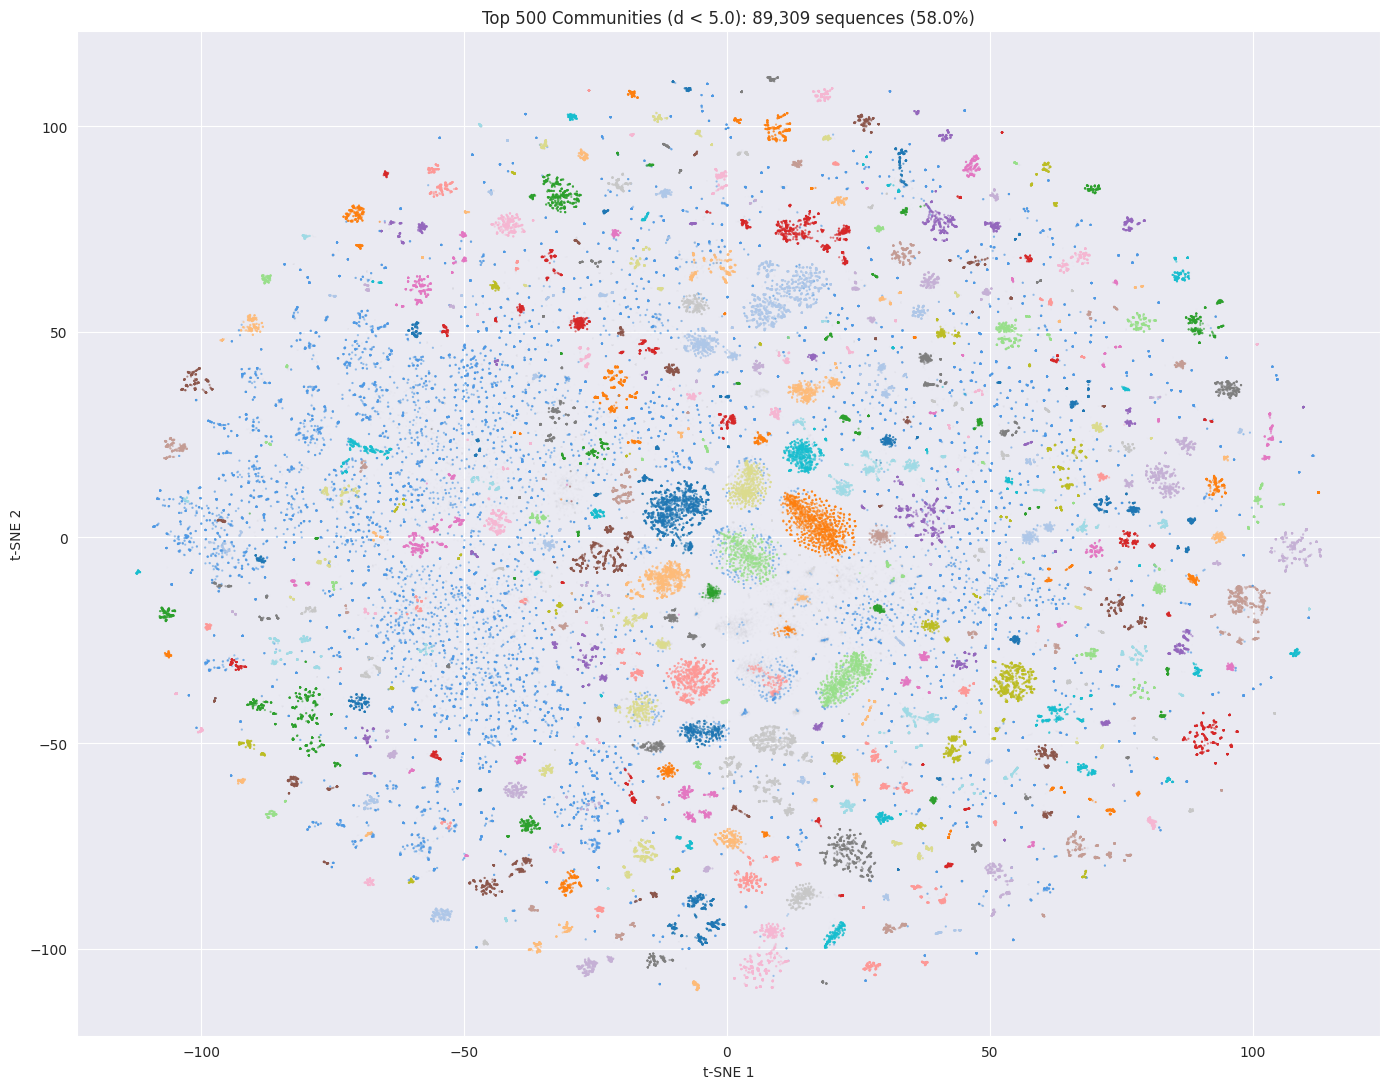

Top 500 communities cover 89,309 sequences (58.0% of total, 72.1% of clustered)
Smallest in top 500: 41


In [20]:
# Visualize top 500 communities on t-SNE
top_n = 500
top_comps_500 = np.argsort(-component_sizes)[:top_n]
# Only keep communities with size > 1
top_comps_500 = top_comps_500[component_sizes[top_comps_500] > 1]

comp_to_rank_500 = np.full(len(component_sizes), -1, dtype = np.int32)
for rank, comp_id in enumerate(top_comps_500):
    comp_to_rank_500[comp_id] = rank
seq_rank_500 = comp_to_rank_500[component_labels]

seq_comp_sizes = component_sizes[component_labels]
is_singleton = seq_comp_sizes == 1

# Use a cycling colormap — spatially separated so reuse is fine
cmap500 = plt.cm.get_cmap('tab20', 20)
colors = np.full((n_sequences, 4), [0.85, 0.85, 0.85, 0.08], dtype = np.float32)

# Non-singleton, outside top 500: light blue
other = (~is_singleton) & (seq_rank_500 == -1)
colors[other] = [0.3, 0.6, 0.9, 0.3]

# Top 500: cycle through 20 colors
for rank in range(len(top_comps_500)):
    mask = seq_rank_500 == rank
    colors[mask] = cmap500(rank % 20)
    colors[mask, 3] = 0.6

fig, ax = plt.subplots(figsize = (14, 11))
ax.scatter(tsne_result[is_singleton, 0], tsne_result[is_singleton, 1],
           c = colors[is_singleton], s = 0.05, rasterized = True)
fg = ~is_singleton
ax.scatter(tsne_result[fg, 0], tsne_result[fg, 1],
           c = colors[fg], s = 0.3, rasterized = True)

n_in_top = sum(component_sizes[c] for c in top_comps_500)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'Top {len(top_comps_500)} Communities (d < {d_threshold}): '
             f'{n_in_top:,} sequences ({100 * n_in_top / n_sequences:.1f}%)')
plt.tight_layout()
plt.show()

print(f'Top {len(top_comps_500)} communities cover {n_in_top:,} sequences '
      f'({100 * n_in_top / n_sequences:.1f}% of total, '
      f'{100 * n_in_top / n_clustered:.1f}% of clustered)')
print(f'Smallest in top {len(top_comps_500)}: {component_sizes[top_comps_500[-1]]:,}')

Singletons: 29,738 (median length: 123,238 bp)
Clustered:  124,302 (median length: 172,932 bp)


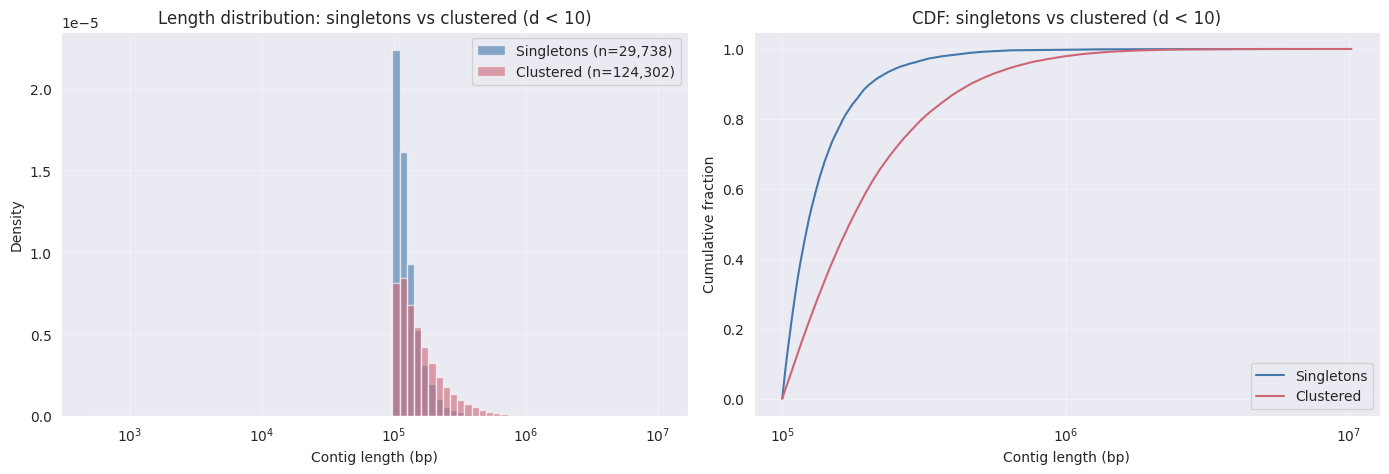

In [21]:
# Length distribution: singletons vs clustered at d < 10
# Uses component_labels and component_sizes from cell 22

seq_community_size = component_sizes[component_labels]
singleton_mask = seq_community_size == 1
clustered_mask = ~singleton_mask

lengths = kmers[:, 0]
singleton_lengths = lengths[singleton_mask]
clustered_lengths = lengths[clustered_mask]

print(f'Singletons: {singleton_mask.sum():,} (median length: {np.median(singleton_lengths):,.0f} bp)')
print(f'Clustered:  {clustered_mask.sum():,} (median length: {np.median(clustered_lengths):,.0f} bp)')

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# Left: overlapping histograms
bins = np.logspace(np.log10(500), np.log10(lengths.max()), 80)
axes[0].hist(singleton_lengths, bins = bins, alpha = 0.6,
             label = f'Singletons (n={singleton_mask.sum():,})', density = True, color = '#4477AA')
axes[0].hist(clustered_lengths, bins = bins, alpha = 0.6,
             label = f'Clustered (n={clustered_mask.sum():,})', density = True, color = '#CC6677')
axes[0].set_xscale('log')
axes[0].set_xlabel('Contig length (bp)')
axes[0].set_ylabel('Density')
axes[0].set_title('Length distribution: singletons vs clustered (d < 10)')
axes[0].legend()
axes[0].grid(True, alpha = 0.3)

# Right: CDFs
for data, label, color in [
    (singleton_lengths, 'Singletons', '#4477AA'),
    (clustered_lengths, 'Clustered', '#CC6677'),
]:
    sorted_d = np.sort(data)
    cdf = np.arange(1, len(sorted_d) + 1) / len(sorted_d)
    axes[1].plot(sorted_d, cdf, label = label, color = color, linewidth = 1.5)

axes[1].set_xscale('log')
axes[1].set_xlabel('Contig length (bp)')
axes[1].set_ylabel('Cumulative fraction')
axes[1].set_title('CDF: singletons vs clustered (d < 10)')
axes[1].legend()
axes[1].grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_880065/2103436175.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 20)


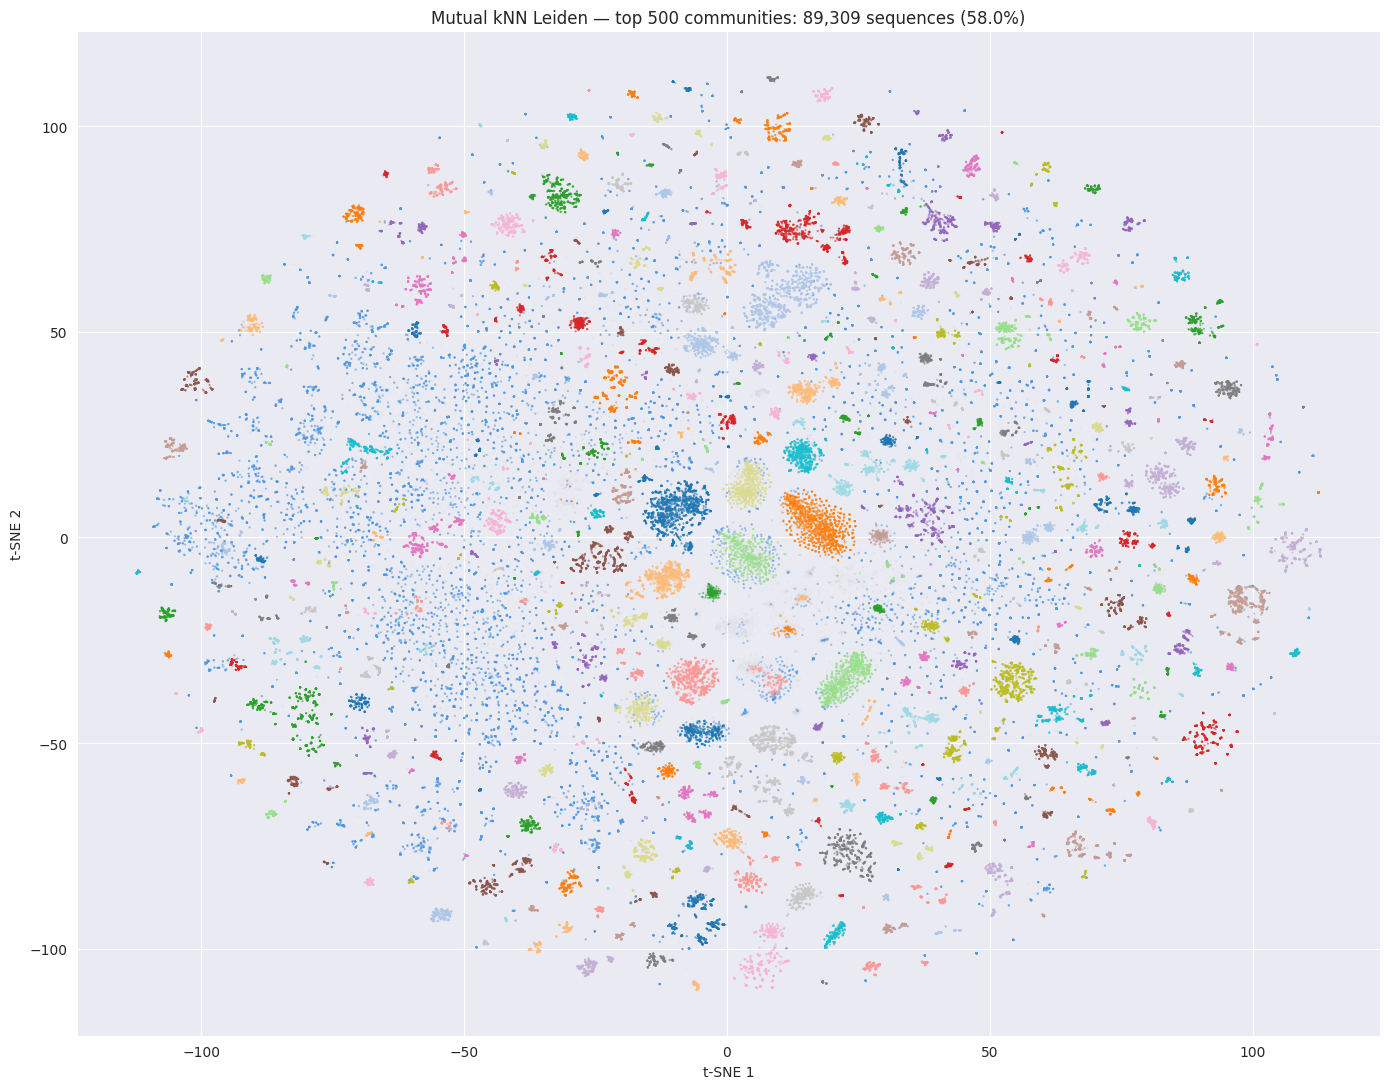

Top 500 communities cover 89,309 sequences (58.0% of total, 72.1% of clustered)
Smallest in top 500: 41


In [23]:
# Overlay mutual kNN Leiden communities on t-SNE
top_n = 500
top_comps = np.argsort(-component_sizes)[:top_n]
top_comps = top_comps[component_sizes[top_comps] > 1]

comp_to_rank = np.full(len(component_sizes), -1, dtype = np.int32)
for rank, comp_id in enumerate(top_comps):
    comp_to_rank[comp_id] = rank
seq_rank = comp_to_rank[component_labels]

seq_comp_sizes = component_sizes[component_labels]
is_singleton = seq_comp_sizes == 1

# Color scheme: grey singletons, light blue other clusters, cycling colors for top N
cmap = plt.cm.get_cmap('tab20', 20)
colors = np.full((n_sequences, 4), [0.85, 0.85, 0.85, 0.08], dtype = np.float32)

# Non-singleton, outside top N: light blue
other = (~is_singleton) & (seq_rank == -1)
colors[other] = [0.3, 0.6, 0.9, 0.3]

# Top N: cycle through 20 colors
for rank in range(len(top_comps)):
    mask = seq_rank == rank
    colors[mask] = cmap(rank % 20)
    colors[mask, 3] = 0.6

fig, ax = plt.subplots(figsize = (14, 11))

# Plot singletons first (background), then clustered (foreground)
ax.scatter(tsne_result[is_singleton, 0], tsne_result[is_singleton, 1],
           c = colors[is_singleton], s = 0.05, rasterized = True)
fg = ~is_singleton
ax.scatter(tsne_result[fg, 0], tsne_result[fg, 1],
           c = colors[fg], s = 0.3, rasterized = True)

n_in_top = sum(component_sizes[c] for c in top_comps)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'Mutual kNN Leiden — top {len(top_comps)} communities: '
             f'{n_in_top:,} sequences ({100 * n_in_top / n_sequences:.1f}%)')
plt.tight_layout()
plt.show()

print(f'Top {len(top_comps)} communities cover {n_in_top:,} sequences '
      f'({100 * n_in_top / n_sequences:.1f}% of total, '
      f'{100 * n_in_top / n_clustered:.1f}% of clustered)')
print(f'Smallest in top {len(top_comps)}: {component_sizes[top_comps[-1]]:,}')

In [ ]:
# Save in-degree capped graph for MCL (ABC format: nodeA\tnodeB\tweight)
# Re-parses TSV and caps in-degree
from collections import defaultdict

d_threshold = 5.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_100.tsv'
n_sequences = len(embeddings)
out_path = 'Runs/graph_capped100_d5_100kbp.tsv'

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse directed edges
print(f'Parsing edges with d < {d_threshold}...')
directed_edges = []
with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  {i + 1:,} / {n_sequences:,}...')

print(f'Directed edges: {len(directed_edges):,}')

# Cap in-degree
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

n_dropped = 0
n_written = 0
with open(out_path, 'w') as f:
    for j, sources in incoming.items():
        if len(sources) > max_in_degree:
            sources.sort()
            n_dropped += len(sources) - max_in_degree
            sources = sources[:max_in_degree]
        for dist, i in sources:
            weight = 1.0 / (dist + epsilon)
            f.write(f'{embedding_ids[i]}\t{embedding_ids[j]}\t{weight:.6f}\n')
            n_written += 1

del directed_edges, incoming

import os
size_mb = os.path.getsize(out_path) / 1e6
print(f'\nEdges dropped by capping: {n_dropped:,}')
print(f'Saved {n_written:,} edges to {out_path} ({size_mb:.1f} MB)')
print(f'Format: source_id<TAB>target_id<TAB>weight (ABC format for MCL)')

In [5]:
# Pairwise distance / GC validation for in-degree capped Leiden (top 3)
# Uses component_labels/component_sizes from Cell 19 (in-degree capped)
rng_val = np.random.default_rng(42)
sorted_labels = np.argsort(-component_sizes)

for rank in range(3):
    label = sorted_labels[rank]
    comm_idx = np.where(component_labels == label)[0]
    size = component_sizes[label]
    n_sample = min(1000, size)

    if n_sample < size:
        sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
    else:
        sample_idx = comm_idx

    sample_emb = embeddings[sample_idx]
    sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    np.fill_diagonal(sq_dists, 0)
    d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

    gc = one_mers[comm_idx, 1]
    comm_lengths = lengths[comm_idx]

    print(f'Community #{rank + 1} (size {size:,}, sample {n_sample}):')
    print(f'  Distances: mean={d.mean():.2f}, std={d.std():.2f}, '
          f'median={np.median(d):.2f}, range={d.min():.2f}-{d.max():.2f}')
    print(f'  GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
          f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}%')
    print(f'  Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
          f'median={np.median(comm_lengths) / 1000:.1f} kbp, '
          f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
    print(f'  Ratio to global mean: {d.mean() / 18.70:.2f}')
    print()

    del sq_norms, sq_dists

Community #1 (size 55,965, sample 1000):
  Distances: mean=12.50, std=2.15, median=12.27, range=2.25-24.35
  GC: mean=62.7%, std=3.0%, range=47.1%-80.2%
  Length: mean=50.7 kbp, median=41.7 kbp, range=10.0-664.0 kbp
  Ratio to global mean: 0.67

Community #2 (size 31,430, sample 1000):
  Distances: mean=12.42, std=2.26, median=12.41, range=1.73-26.96
  GC: mean=28.7%, std=3.5%, range=20.4%-69.0%
  Length: mean=39.2 kbp, median=28.9 kbp, range=10.0-976.6 kbp
  Ratio to global mean: 0.66

Community #3 (size 28,049, sample 1000):
  Distances: mean=12.31, std=2.18, median=12.31, range=2.46-27.88
  GC: mean=57.9%, std=3.8%, range=30.3%-71.8%
  Length: mean=54.1 kbp, median=39.4 kbp, range=10.0-1951.0 kbp
  Ratio to global mean: 0.66



In [7]:
# In-degree capped Leiden at d=7, cap=100, weights=1/(d+0.1)
import igraph as ig
import leidenalg
from collections import defaultdict

d_threshold = 7.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_10.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge list with d < {d_threshold}...')
directed_edges = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Check max in-degree before capping
in_deg = defaultdict(int)
for _, j, _ in directed_edges:
    in_deg[j] += 1
max_orig = max(in_deg.values()) if in_deg else 0
print(f'Max in-degree before capping: {max_orig:,}')
del in_deg

# Pass 2: cap in-degree
print(f'Capping in-degree to {max_in_degree}...')
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

capped_edges = []
capped_weights = []
n_dropped = 0

for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        capped_edges.append((i, j))
        capped_weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming

print(f'Edges after capping: {len(capped_edges):,} (dropped {n_dropped:,})')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = capped_edges, directed = True)
g.es['weight'] = capped_weights
del capped_edges, capped_weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, in-degree capped at {max_in_degree})...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped7_labels = np.array(partition.membership)
capped7_sizes = np.bincount(capped7_labels)
n_components = len(capped7_sizes)
n_singletons = (capped7_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped7_sizes[capped7_sizes > 1])[::-1]
n_clustered = capped7_sizes[capped7_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on in-degree capped graph (d < {d_threshold}, cap = {max_in_degree})')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

# Pairwise distance / GC validation on top 3
print(f'\n{"=" * 60}')
print(f'Pairwise validation (top 3 communities)')
print(f'{"=" * 60}')
rng_val = np.random.default_rng(42)
sorted_labels = np.argsort(-capped7_sizes)

for rank in range(3):
    label = sorted_labels[rank]
    comm_idx = np.where(capped7_labels == label)[0]
    size = capped7_sizes[label]
    n_sample = min(1000, size)

    if n_sample < size:
        sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
    else:
        sample_idx = comm_idx

    sample_emb = embeddings[sample_idx]
    sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    np.fill_diagonal(sq_dists, 0)
    d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

    gc = one_mers[comm_idx, 1]
    comm_lengths = lengths[comm_idx]

    print(f'\nCommunity #{rank + 1} (size {size:,}, sample {n_sample}):')
    print(f'  Distances: mean={d.mean():.2f}, std={d.std():.2f}, '
          f'median={np.median(d):.2f}, range={d.min():.2f}-{d.max():.2f}')
    print(f'  GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
          f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}%')
    print(f'  Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
          f'median={np.median(comm_lengths) / 1000:.1f} kbp, '
          f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
    print(f'  Ratio to global mean: {d.mean() / 18.70:.2f}')

    del sq_norms, sq_dists

Building directed edge list with d < 7.0...
  Parsed 1,000,000 / 3,039,927... (4,534,024 edges)
  Parsed 2,000,000 / 3,039,927... (9,079,894 edges)
  Parsed 3,000,000 / 3,039,927... (13,608,081 edges)
Total directed edges: 13,789,958
Max in-degree before capping: 10,304
Capping in-degree to 100...
Edges after capping: 9,267,067 (dropped 4,522,891)
Building igraph graph...
Graph: 3,039,927 vertices, 6,744,130 edges
Weight range: 0.1408 - 10.0000, mean: 0.1949
Running Leiden (resolution=1.0, weighted, in-degree capped at 100)...

Leiden on in-degree capped graph (d < 7.0, cap = 100)
Quality (modularity): 2608341.2673
Total communities: 2,378,174
Singletons: 2,300,293 (75.7%)
Non-singleton communities: 77,881
Clustered sequences: 739,634 (24.3%)
  Size range: 2 - 13,968
  Mean size: 9.5
  Median size: 2

Top 20 communities:
    1. 13,968 sequences
    2. 11,120 sequences
    3. 10,613 sequences
    4. 8,430 sequences
    5. 8,172 sequences
    6. 7,490 sequences
    7. 7,233 sequences
   

In [8]:
# In-degree capped Leiden at d=5, cap=100, weights=1/(d+0.1)
import igraph as ig
import leidenalg
from collections import defaultdict

d_threshold = 5.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_10.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge list with d < {d_threshold}...')
directed_edges = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Check max in-degree before capping
in_deg = defaultdict(int)
for _, j, _ in directed_edges:
    in_deg[j] += 1
max_orig = max(in_deg.values()) if in_deg else 0
print(f'Max in-degree before capping: {max_orig:,}')
del in_deg

# Pass 2: cap in-degree
print(f'Capping in-degree to {max_in_degree}...')
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

capped_edges = []
capped_weights = []
n_dropped = 0

for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        capped_edges.append((i, j))
        capped_weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming

print(f'Edges after capping: {len(capped_edges):,} (dropped {n_dropped:,})')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = capped_edges, directed = True)
g.es['weight'] = capped_weights
del capped_edges, capped_weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, in-degree capped at {max_in_degree})...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped5_labels = np.array(partition.membership)
capped5_sizes = np.bincount(capped5_labels)
n_components = len(capped5_sizes)
n_singletons = (capped5_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped5_sizes[capped5_sizes > 1])[::-1]
n_clustered = capped5_sizes[capped5_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on in-degree capped graph (d < {d_threshold}, cap = {max_in_degree})')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

# Pairwise distance / GC validation on top 3
print(f'\n{"=" * 60}')
print(f'Pairwise validation (top 3 communities)')
print(f'{"=" * 60}')
rng_val = np.random.default_rng(42)
sorted_labels = np.argsort(-capped5_sizes)

for rank in range(3):
    label = sorted_labels[rank]
    comm_idx = np.where(capped5_labels == label)[0]
    size = capped5_sizes[label]
    n_sample = min(1000, size)

    if n_sample < size:
        sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
    else:
        sample_idx = comm_idx

    sample_emb = embeddings[sample_idx]
    sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    np.fill_diagonal(sq_dists, 0)
    d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

    gc = one_mers[comm_idx, 1]
    comm_lengths = lengths[comm_idx]

    print(f'\nCommunity #{rank + 1} (size {size:,}, sample {n_sample}):')
    print(f'  Distances: mean={d.mean():.2f}, std={d.std():.2f}, '
          f'median={np.median(d):.2f}, range={d.min():.2f}-{d.max():.2f}')
    print(f'  GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
          f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}%')
    print(f'  Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
          f'median={np.median(comm_lengths) / 1000:.1f} kbp, '
          f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
    print(f'  Ratio to global mean: {d.mean() / 18.70:.2f}')

    del sq_norms, sq_dists

Building directed edge list with d < 5.0...
  Parsed 1,000,000 / 3,039,927... (1,234,971 edges)
  Parsed 2,000,000 / 3,039,927... (2,468,001 edges)
  Parsed 3,000,000 / 3,039,927... (3,682,604 edges)
Total directed edges: 3,731,841
Max in-degree before capping: 1,541
Capping in-degree to 100...
Edges after capping: 3,230,777 (dropped 501,064)
Building igraph graph...
Graph: 3,039,927 vertices, 2,083,900 edges
Weight range: 0.1961 - 10.0000, mean: 0.2670
Running Leiden (resolution=1.0, weighted, in-degree capped at 100)...

Leiden on in-degree capped graph (d < 5.0, cap = 100)
Quality (modularity): 1108103.2906
Total communities: 2,748,027
Singletons: 2,685,223 (88.3%)
Non-singleton communities: 62,804
Clustered sequences: 354,704 (11.7%)
  Size range: 2 - 5,620
  Mean size: 5.6
  Median size: 2

Top 20 communities:
    1. 5,620 sequences
    2. 2,986 sequences
    3. 2,738 sequences
    4. 2,213 sequences
    5. 1,979 sequences
    6. 1,835 sequences
    7. 1,623 sequences
    8. 1,550

In [25]:
# MCL pairwise GC validation across inflation values (100 kbp data)
# MCL output: one cluster per line, tab-separated sequence IDs
import os

mcl_dir = 'Runs/MCL_100kbp'
inflations = [1.4, 2.0, 3.0, 4.0, 5.0, 6.0]
id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}
n_sequences = len(embeddings)
rng_val = np.random.default_rng(42)

for I in inflations:
    cluster_file = os.path.join(mcl_dir, f'mcl_I{I}.clusters')
    if not os.path.exists(cluster_file):
        print(f'I={I}: file not found, skipping')
        continue

    # Parse clusters
    clusters = []
    with open(cluster_file) as f:
        for line in f:
            members = line.rstrip('\n').split('\t')
            if len(members) > 1:
                indices = [id_to_idx[m] for m in members]
                clusters.append(np.array(indices))

    clusters.sort(key = len, reverse = True)
    n_clustered = sum(len(c) for c in clusters)

    print(f'{"=" * 70}')
    print(f'MCL I={I}  |  {len(clusters):,} non-singleton clusters  |  '
          f'largest: {len(clusters[0]):,}  |  clustered: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
    print(f'{"=" * 70}')

    for rank in range(min(3, len(clusters))):
        comm_idx = clusters[rank]
        size = len(comm_idx)
        n_sample = min(1000, size)

        if n_sample < size:
            sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
        else:
            sample_idx = comm_idx

        sample_emb = embeddings[sample_idx]
        sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
        sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
        np.maximum(sq_dists, 0, out = sq_dists)
        np.fill_diagonal(sq_dists, 0)
        d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

        gc = one_mers[comm_idx, 1]
        comm_lengths = lengths[comm_idx]
        gc_span = 100 * (gc.max() - gc.min())

        print(f'\n  #{rank + 1} (size {size:,}, sample {n_sample}):')
        print(f'    Distances: mean={d.mean():.2f}, median={np.median(d):.2f}, '
              f'range={d.min():.2f}-{d.max():.2f}')
        print(f'    GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
              f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}% (span {gc_span:.0f} pp)')
        print(f'    Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
              f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')

        del sq_norms, sq_dists

    print()

MCL I=1.4  |  7,693 non-singleton clusters  |  largest: 1,056  |  clustered: 123,783 (80.4%)

  #1 (size 1,056, sample 1000):
    Distances: mean=5.73, median=5.70, range=1.42-10.17
    GC: mean=59.3%, std=0.9%, range=55.0%-62.2% (span 7 pp)
    Length: mean=187.4 kbp, range=100.0-923.8 kbp

  #2 (size 1,022, sample 1000):
    Distances: mean=5.48, median=5.53, range=0.82-8.23
    GC: mean=28.6%, std=0.9%, range=24.5%-33.1% (span 9 pp)
    Length: mean=180.7 kbp, range=100.1-976.6 kbp

  #3 (size 835, sample 835):
    Distances: mean=5.31, median=5.35, range=0.85-8.42
    GC: mean=29.0%, std=0.9%, range=24.3%-32.9% (span 9 pp)
    Length: mean=196.4 kbp, range=100.0-1148.8 kbp

MCL I=2.0  |  9,704 non-singleton clusters  |  largest: 333  |  clustered: 123,777 (80.4%)

  #1 (size 333, sample 333):
    Distances: mean=5.25, median=5.28, range=0.29-8.78
    GC: mean=66.2%, std=1.0%, range=60.8%-68.9% (span 8 pp)
    Length: mean=229.0 kbp, range=100.2-2491.1 kbp

  #2 (size 300, sample 30